# Seq2Seq time series outlier detection on ECG data

## Method

The [Sequence-to-Sequence](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) (Seq2Seq) outlier detector consists of 2 main building blocks: an encoder and a decoder. The encoder consists of a [Bidirectional](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) which processes the input sequence and initializes the decoder. The LSTM decoder then makes sequential predictions for the output sequence. In our case, the decoder aims to reconstruct the input sequence. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is measured as the mean squared error (MSE) between the input and the reconstructed instance. 

Since even for normal data the reconstruction error can be state-dependent, we add an outlier threshold estimator network to the Seq2Seq model. This network takes in the hidden state of the decoder at each timestep and predicts the estimated reconstruction error for normal data. As a result, the outlier threshold is not static and becomes a function of the model state. This is similar to [Park et al. (2017)](https://arxiv.org/pdf/1711.00614.pdf), but while they train the threshold estimator separately from the Seq2Seq model with a Support-Vector Regressor, we train a neural net regression network end-to-end with the Seq2Seq model.

The detector is first trained on a batch of unlabeled, but normal (*inlier*) data. Unsupervised training is desireable since labeled data is often scarce. The Seq2Seq outlier detector is suitable for both **univariate and multivariate time series**.

## Dataset

The outlier detector needs to spot anomalies in electrocardiograms (ECG's). The dataset contains 5000 ECG's, originally obtained from [Physionet](https://archive.physionet.org/cgi-bin/atm/ATM) under the name *BIDMC Congestive Heart Failure Database(chfdb)*, record *chf07*. The data has been pre-processed in 2 steps: first each heartbeat is extracted, and then each beat is made equal length via interpolation. The data is labeled and contains 5 classes. The first class which contains almost 60% of the observations is seen as *normal* while the others are outliers. The detector is trained on heartbeats from the first class and needs to flag the other classes as anomalies.

This notebook requires the `seaborn` package for visualization which can be installed via `pip`:

In [ ]:
!pip install seaborn

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

from alibi_detect.od import OutlierSeq2Seq
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_ecg
from alibi_detect.utils.visualize import plot_roc

## Load dataset

Flip train and test data because there are only 500 ECG's in the original training set and 4500 in the test set:

In [2]:
(X_test, y_test), (X_train, y_train) = fetch_ecg(return_X_y=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4500, 140) (4500,)
(500, 140) (500,)


Since we treat the first class as the normal, *inlier* data and the rest of *X_train* as outliers, we need to adjust the training (inlier) data and the labels of the test set.

In [3]:
inlier_idx = np.where(y_train == 1)[0]
X_inlier, y_inlier = X_train[inlier_idx], np.zeros_like(y_train[inlier_idx])
outlier_idx = np.where(y_train != 1)[0]
X_outlier, y_outlier = X_train[outlier_idx], y_train[outlier_idx]
y_test[y_test == 1] = 0  # class 1 represent the inliers
y_test[y_test != 0] = 1
print(X_inlier.shape, X_outlier.shape)

(2627, 140) (1873, 140)


Some of the outliers in *X_train* are used in combination with some of the inlier instances to infer the threshold level:

In [4]:
n_threshold = 1000
perc_inlier = 60
n_inlier = int(perc_inlier * .01 * n_threshold)
n_outlier = int((100 - perc_inlier) * .01 * n_threshold)
idx_thr_in = np.random.choice(X_inlier.shape[0], n_inlier, replace=False)
idx_thr_out = np.random.choice(X_outlier.shape[0], n_outlier, replace=False)
X_threshold = np.concatenate([X_inlier[idx_thr_in], X_outlier[idx_thr_out]], axis=0)
y_threshold = np.zeros(n_threshold).astype(int)
y_threshold[-n_outlier:] = 1
print(X_threshold.shape, y_threshold.shape)

(1000, 140) (1000,)


Apply min-max scaling between 0 and 1 to the observations using the inlier data:

In [5]:
xmin, xmax = X_inlier.min(), X_inlier.max()
rng = (0, 1)
X_inlier = ((X_inlier - xmin) / (xmax - xmin)) * (rng[1] - rng[0]) + rng[0]
X_threshold = ((X_threshold - xmin) / (xmax - xmin)) * (rng[1] - rng[0]) + rng[0]
X_test = ((X_test - xmin) / (xmax - xmin)) * (rng[1] - rng[0]) + rng[0]
X_outlier = ((X_outlier - xmin) / (xmax - xmin)) * (rng[1] - rng[0]) + rng[0]
print('Inlier: min {:.2f} --- max {:.2f}'.format(X_inlier.min(), X_inlier.max()))
print('Threshold: min {:.2f} --- max {:.2f}'.format(X_threshold.min(), X_threshold.max()))
print('Test: min {:.2f} --- max {:.2f}'.format(X_test.min(), X_test.max()))

Inlier: min 0.00 --- max 1.00
Threshold: min 0.00 --- max 0.99
Test: min 0.11 --- max 0.92


Reshape the observations to *(batch size, sequence length, features)* for the detector:

In [6]:
shape = (-1, X_inlier.shape[1], 1)
X_inlier = X_inlier.reshape(shape)
X_threshold = X_threshold.reshape(shape)
X_test = X_test.reshape(shape)
X_outlier = X_outlier.reshape(shape)
print(X_inlier.shape, X_threshold.shape, X_test.shape)

(2627, 140, 1) (1000, 140, 1) (500, 140, 1)


We can now visualize scaled instances from each class:

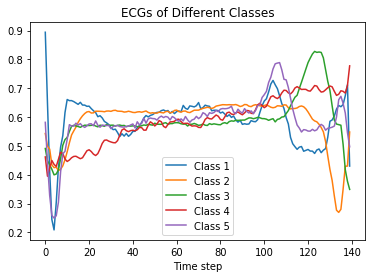

In [7]:
idx_plt = [np.where(y_outlier == i)[0][0] for i in list(np.unique(y_outlier))]
X_plt = np.concatenate([X_inlier[0:1], X_outlier[idx_plt]], axis=0)

for i in range(X_plt.shape[0]):
    plt.plot(X_plt[i], label='Class ' + str(i+1))
plt.title('ECGs of Different Classes')
plt.xlabel('Time step')
plt.legend()
plt.show()

## Load or define Seq2Seq outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [8]:
load_outlier_detector = True

In [9]:
filepath = 'my_path'  # change to (absolute) directory where model is downloaded
detector_type = 'outlier'
dataset = 'ecg'
detector_name = 'OutlierSeq2Seq'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector

    # initialize outlier detector
    od = OutlierSeq2Seq(1,
                        X_inlier.shape[1],  # sequence length
                        threshold=None,
                        latent_dim=40)

    # train
    od.fit(X_inlier,
           epochs=100,
           verbose=False)

    # save the trained outlier detector
    save_detector(od, filepath)

Let's inspect how well the sequence-to-sequence model can predict the ECG's of the inlier and outlier classes. The predictions in the charts below are made on ECG's from the test set:

In [10]:
ecg_pred = od.seq2seq.decode_seq(X_test)[0]

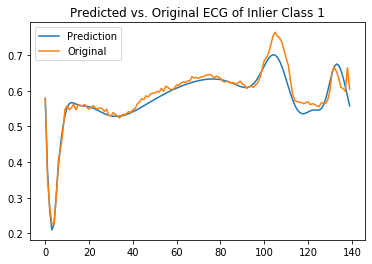

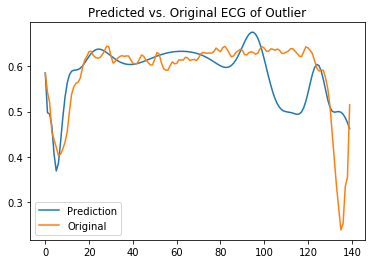

In [11]:
i_normal = np.where(y_test == 0)[0][0]
plt.plot(ecg_pred[i_normal], label='Prediction')
plt.plot(X_test[i_normal], label='Original')
plt.title('Predicted vs. Original ECG of Inlier Class 1')
plt.legend()
plt.show()

i_outlier = np.where(y_test == 1)[0][0]
plt.plot(ecg_pred[i_outlier], label='Prediction')
plt.plot(X_test[i_outlier], label='Original')
plt.title('Predicted vs. Original ECG of Outlier')
plt.legend()
plt.show()

It is clear that the model can reconstruct the inlier class but struggles with the outliers.

If we trained a model from scratch, the warning thrown when we initialized the model tells us that we need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a time series of instances and specify what percentage of those we consider to be normal via `threshold_perc`, equal to the percentage of *Class 1* in *X_threshold*. The `outlier_perc` parameter defines the percentage of features used to define the outlier threshold. In this example, the number of features considered per instance equals 140 (1 for each timestep). We set the ```outlier_perc``` at 95, which means that we will use the 95% features with highest reconstruction error, adjusted for by the threshold estimate.

In [12]:
od.infer_threshold(X_threshold, outlier_perc=95, threshold_perc=perc_inlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.002807901981854227


Let's save the outlier detector with the updated threshold:

In [13]:
save_detector(od, filepath)

We can load the same detector via `load_detector`:

In [14]:
od = load_detector(filepath)

## Detect outliers

In [15]:
od_preds = od.predict(X_test,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

## Display results

F1 score, accuracy, recall and confusion matrix:

F1 score: 0.964 -- Accuracy: 0.970 -- Precision: 0.975 -- Recall: 0.952


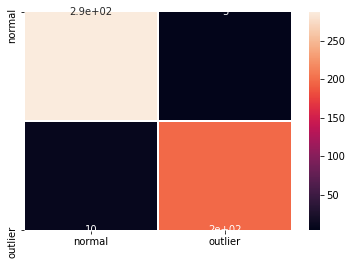

In [16]:
y_pred = od_preds['data']['is_outlier']
labels = ['normal', 'outlier']
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('F1 score: {:.3f} -- Accuracy: {:.3f} -- Precision: {:.3f} -- Recall: {:.3f}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

We can also plot the ROC curve based on the instance level outlier scores:

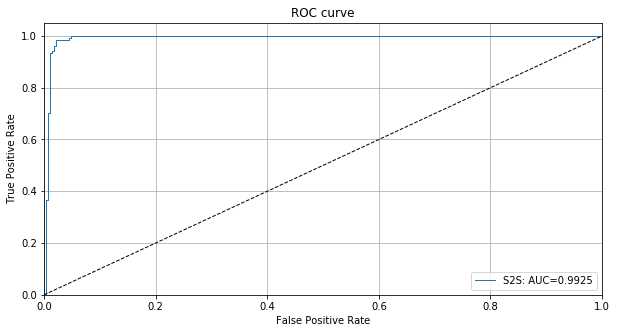

In [17]:
roc_data = {'S2S': {'scores': od_preds['data']['instance_score'], 'labels': y_test}}
plot_roc(roc_data)